# 原代码

C:\Users\ZhouXunZhe\AppData\Local\Temp\ipykernel_19772\3517450483.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['方向'] = 1
C:\Users\ZhouXunZhe\AppData\Local\Temp\ipykernel_19772\3517450483.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['方向'] = -1


                                         当周期选币  下周期策略涨跌幅         净值
time                                                               
2021-01-01         RSR-USDT(1) 1INCH-USDT(-1)   0.134425   1.134425
2021-01-02        DOGE-USDT(1) 1INCH-USDT(-1)  -0.073328   1.051239
2021-01-03         LRC-USDT(1) THETA-USDT(-1)   0.200974   1.262511
2021-01-04         LRC-USDT(1) ALPHA-USDT(-1)   0.122085   1.416645
2021-01-05           LRC-USDT(1) SOL-USDT(-1)  -0.022311   1.385039
2021-01-06           XLM-USDT(1) LRC-USDT(-1)   0.004343   1.391053
2021-01-07         CVC-USDT(1) 1INCH-USDT(-1)  -0.049650   1.321987
2021-01-08           SOL-USDT(1) CVC-USDT(-1)   0.063665   1.406152
2021-01-09           MKR-USDT(1) CVC-USDT(-1)   0.004616   1.412642
2021-01-10           ZEN-USDT(1) EOS-USDT(-1)   0.108645   1.566119
2021-01-11           ZEN-USDT(1) BCH-USDT(-1)   0.087620   1.703343
2021-01-12           CVC-USDT(1) AXS-USDT(-1)  -0.060282   1.600661
2021-01-13          RUNE-USDT(1) SOL-USDT(-1)   

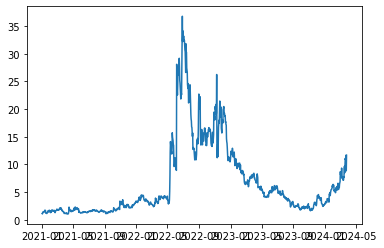

In [44]:
"""
邢不行 - b圈量化交易训练营
day3 - 中性策略
作者：邢不行
微信：xbx1717
"""
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('expand_frame_repr', False)  # 当列太多时不换行
pd.set_option('display.max_rows', 5000)  # 最多显示数据的行数

# 回测时间
start_date = '2021-01-01'
end_date = '2024-03-25'

# 回测参数
select_coin_num = 1  # 单边选币数量
leverage = 1  # 杠杆比例
period = '24H'  # 周期
c_rate = 2.5 / 10000  # 手续费

# 因子 False：从大到小排序，做多大的，做空小的。True：从小到大排序，做多小的，做空大的。
factor_class_dict = {'涨跌幅': False}

# 导入数据
df = pd.read_csv(f'all_coin_factor_data_{period}.csv', encoding='gbk', parse_dates=['time'])
df = df[['time', 'symbol', '下周期币种涨跌幅'] + list(factor_class_dict.keys())]

# 筛选日期范围
df = df[df['time'] >= pd.to_datetime(start_date)]
df = df[df['time'] <= pd.to_datetime(end_date)]


# 计算每个因子的排名
factor_rank_cols = []
for f in list(factor_class_dict.keys()):
    df[f'{f}_rank'] = df.groupby('time')[f].rank(method='first', ascending=factor_class_dict[f])

# 计算综合排名
df['因子'] = df[[i+'_rank'  for i in list(factor_class_dict.keys())]].sum(axis=1, skipna=False)

# 根据因子对比进行排名
# 从小到大排序 - 做多
df['排名1'] = df.groupby('time')['因子'].rank(method='first')
df1 = df[(df['排名1'] <= select_coin_num)]
df1['方向'] = 1

# 从大到小排序 - 做空
df['排名2'] = df.groupby('time')['因子'].rank(method='first', ascending=False)
df2 = df[(df['排名2'] <= select_coin_num)]
df2['方向'] = -1

# 合并排序结果
df = pd.concat([df1, df2], ignore_index=True)
df['选币'] = df['symbol'] + '(' + df['方向'].astype(str) + ')' + ' '
df = df[['time', 'symbol', '方向', '选币', '下周期币种涨跌幅']]
df.sort_values(by=['time', '方向'], ascending=[True, False], inplace=True)
df.reset_index(drop=True, inplace=True)

# 计算下周期收益
df['下周期交易涨跌幅'] = df['下周期币种涨跌幅'] * df['方向'] * leverage - leverage * c_rate - leverage * c_rate * (1+df['下周期币种涨跌幅']) # 杠杆，多空，并且扣除手续费
select_coin = pd.DataFrame()
select_coin['当周期选币'] = df.groupby('time')['选币'].sum()
select_coin['下周期策略涨跌幅'] = df.groupby('time')['下周期交易涨跌幅'].sum() / (select_coin_num * 2)
select_coin['净值'] = (select_coin['下周期策略涨跌幅'] + 1).cumprod()
print(select_coin)

# 画图
select_coin.reset_index(inplace=True)
plt.plot(select_coin['time'], select_coin['净值'])
plt.show()


# 代码解析

这段代码是一个数字货币多空策略的回测脚本，用于在一个特定的时间段内通过对数字货币的特定因子进行分析，以决定哪些货币做多（看涨）和哪些做空（看跌）。下面是详细的逻辑分析：

### **数据准备和参数设置**

**回测时间**：设置了回测的开始日期和结束日期：设置回测的时间范围从2021-01-01到2024-03-25。

**回测参数**：包括单边选币数量、杠杆比例、数据的时间周期和手续费率：
* 设定选币数量为1，即每个周期选择一个数字货币进行多头和空头操作。
* 设置杠杆比例为1，表示不使用额外的杠杆。
* 设置周期为24H，即以日为单位进行交易。
* 设置手续费比率。

**因子定义**：factor_class_dict字典定义了用于排名的因子（原代码给的是涨跌幅）及其排序方式（False表示做多因子值大的，做空因子值小的）。

**数据导入**：读取包含所有币种因子数据的CSV文件，并筛选出所需的列：
* 从CSV文件中导入数据，这个CSV文件包含了不同时间、不同货币的因子数据。
* 原代码中只保留时间、货币符号、下周期币种涨跌幅和其他因子数据。

### **回测逻辑**

**因子排名**：对每个因子按照指定的排序方式（升序或降序）进行排名，分别对每个时间点内的所有币种执行：
* 根据factor_class_dict（一个因子及其排序方式的字典）对每个因子进行排名。
* 根据因子值的大小进行排名，支持升序和降序。

**综合排名**：通过合并所有因子的排名来计算综合排名：
* 对所有因子的排名进行求和，计算一个综合排名。

**选币逻辑**：
* 做多：选出综合排名在设定的选币数量范围内（最优）的币种，标记为做多（方向=1）。
* 做空：同样，选出综合排名在设定的选币数量范围内（最差）的币种，但是这次是根据排名的降序来选，标记为做空（方向=-1）。

**合并结果**：将做多和做空的结果合并成一个DataFrame，以便后续处理。

**计算收益**：根据选出的币种和方向，计算下一个周期的预期收益，考虑到杠杆作用和手续费的影响。

**结果汇总**：汇总每个周期内所有选出的币种的收益，计算策略的整体表现。

**绘图**：绘制策略净值随时间变化的图表，以直观展示策略的表现。

### **关键点**
* 杠杆和手续费的影响被纳入了收益计算，这是实际交易中非常重要的考虑因素。
* 策略既考虑了做多也考虑了做空，是一个市场中性策略，意图从市场的波动中双向获利。
* 通过分组排名和选币逻辑，策略试图在每个周期选出最有潜力的币种进行投资。

整体而言，这是一个结合了市场中性理念和量化分析的多空策略，通过对特定因子（这里是涨跌幅）的分析来指导交易决策，旨在实现稳定的收益增长。

# 改进思路

1. 从因子选取出发，使用随机森林选取对收盘价影响最大的k个因子，进行做多和做空，并将这k个因子作为选取的因子
2. 从交易额出发，并非每次全部做多做空，而是学习kelly准则，每次交易一定的比例
3. 从选币数量出发，实现动态选币，每次可以改变选币数量

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 加载数据
df = pd.read_csv(f'all_coin_factor_data_{period}.csv', encoding='gbk', parse_dates=['time'])

# 获取所有列名
all_columns = df.columns.tolist()
print(all_columns)

# 假设factor_columns是所有可能的因子列
factor_columns = [col for col in all_columns if col not in ['time', 'symbol', '下周期币种涨跌幅', 'close']]
print(factor_columns)

# 假设df是你的数据集，'target'是你想要预测的目标（例如下周期的币种涨跌幅）
X = df[factor_columns]  # 选择因子作为特征
y = df['close']  # 目标变量

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 初始化随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
# 训练模型
model.fit(X_train, y_train)
# 获取特征重要性
importances = model.feature_importances_
# 将特征重要性排序
indices = np.argsort(importances)[::-1]

# 打印每个因子及其重要性
for f in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[f]]}: {importances[indices[f]]}")


['time', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trade_num', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', '上市天数', '涨跌幅', '下周期币种涨跌幅', 'Bias_2', 'Cmo_2', 'Atr_2', 'Cci_2', 'Volume_2', 'Psy_2', 'ZhangDieFu_2', 'ZhenFu_2', 'Rsi_2', 'Ic_2', 'Bias_3', 'Cmo_3', 'Atr_3', 'Cci_3', 'Volume_3', 'Psy_3', 'ZhangDieFu_3', 'ZhenFu_3', 'Rsi_3', 'Ic_3', 'Bias_4', 'Cmo_4', 'Atr_4', 'Cci_4', 'Volume_4', 'Psy_4', 'ZhangDieFu_4', 'ZhenFu_4', 'Rsi_4', 'Ic_4', 'Bias_5', 'Cmo_5', 'Atr_5', 'Cci_5', 'Volume_5', 'Psy_5', 'ZhangDieFu_5', 'ZhenFu_5', 'Rsi_5', 'Ic_5', 'Bias_6', 'Cmo_6', 'Atr_6', 'Cci_6', 'Volume_6', 'Psy_6', 'ZhangDieFu_6', 'ZhenFu_6', 'Rsi_6', 'Ic_6', 'Bias_8', 'Cmo_8', 'Atr_8', 'Cci_8', 'Volume_8', 'Psy_8', 'ZhangDieFu_8', 'ZhenFu_8', 'Rsi_8', 'Ic_8', 'Bias_9', 'Cmo_9', 'Atr_9', 'Cci_9', 'Volume_9', 'Psy_9', 'ZhangDieFu_9', 'ZhenFu_9', 'Rsi_9', 'Ic_9', 'Bias_12', 'Cmo_12', 'Atr_12', 'Cci_12', 'Volume_12', 'Psy_12', 'ZhangDieFu_12', 'ZhenFu_12', 'Rsi_

In [45]:
def kelly(
  p: float,  # 获胜概率
  W: float,  # 获胜时的盈利，或止盈点。例如：当上涨时预计盈利为20%，则W=0.2
  L: float,  # 失败时的亏损，或止损点。例如：当下跌10%时止损，则L=0.1
):
  """
  根据“凯利公式”决定买入的仓位比例
  """

  buy_ratio = (p * W - (1 - p) * L) / (W * L)

  if buy_ratio < 0:
    buy_ratio = 0

  return buy_ratio


In [48]:
df = pd.read_csv(f'all_coin_factor_data_{period}.csv', encoding='gbk', parse_dates=['time'])

w_rate = df[df['涨跌幅'] > 0]['涨跌幅'].mean()
l_rate = df[df['涨跌幅'] < 0]['涨跌幅'].mean()
w_prob = len(df[df['涨跌幅'] > 0]['涨跌幅']) / len(df['涨跌幅'])
l_prob = len(df[df['涨跌幅'] < 0]['涨跌幅']) / len(df['涨跌幅'])

w_rate, l_rate, w_prob, l_prob

(0.04399169985574777,
 -0.04109307406326561,
 0.5054933353087425,
 0.49166392732963254)

In [53]:
long_rate = kelly(w_prob, w_rate, -l_rate)
short_rate = kelly(l_prob, -l_rate, w_rate)

long_rate, short_rate

(1.0602725248213867, 0)

C:\Users\ZhouXunZhe\AppData\Local\Temp\ipykernel_19772\2956517979.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['方向'] = 1
C:\Users\ZhouXunZhe\AppData\Local\Temp\ipykernel_19772\2956517979.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['方向'] = -1


0.0 1.0
0.05 1.447681135611654
0.1 2.0314514003137383
0.15000000000000002 2.76837662666832
0.2 3.6692321485502895
0.25 4.7355742364118
0.30000000000000004 5.95711706924322
0.35000000000000003 7.309855782395194
0.4 8.755359791954783
0.45 10.241566501008236
0.5 11.705236659147435
0.55 13.076008219513888
0.6000000000000001 14.281739114490499
0.65 15.254603612472199
0.7000000000000001 15.93724531983574
0.75 16.288227457198026
0.8 16.286076062266922
0.8500000000000001 15.931380848607951
0.9 15.246676123904104
0.9500000000000001 14.274127513529768
1.0 13.071347400588472
1.05 11.705902779602937
1.1 10.249225145895506
1.1500000000000001 8.770663614287155
1.2000000000000002 7.332342067552768
1.25 5.985311124660326
1.3 4.767262419517438
1.35 3.7018380380229585
1.4000000000000001 2.799360878301442
1.4500000000000002 2.058661029518336
1.5 1.469593784037888
1.55 1.0158367193533306
1.6 0.6776043223912518
1.6500000000000001 0.43400906118737326
1.7000000000000002 0.26490525435122064
1.75 0.15215622980

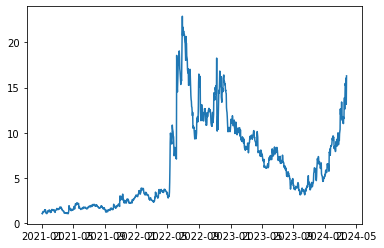

In [78]:
# 选取影响最大的3个因子: Bias_2
# df = pd.read_csv(f'all_coin_factor_data_{period}.csv', encoding='gbk', parse_dates=['time'])

# 回测时间
start_date = '2021-01-01'
end_date = '2024-03-25'

# w_rate = df[df['涨跌幅'] > 0]['涨跌幅'].mean()
# l_rate = df[df['涨跌幅'] < 0]['涨跌幅'].mean()
# w_prob = len(df[df['涨跌幅'] > 0]['涨跌幅']) / len(df['涨跌幅'])
# l_prob = len(df[df['涨跌幅'] < 0]['涨跌幅']) / len(df['涨跌幅'])

# long_rate = kelly(w_prob, w_rate, -l_rate)
# short_rate = kelly(l_prob, -l_rate, w_rate)

# 回测参数
select_coin_num = 1  # 单边选币数量
leverage = 0.9  # 杠杆比例
period = '24H'  # 周期
c_rate = 2.5 / 10000  # 手续费

# 因子 False：从大到小排序，做多大的，做空小的。True：从小到大排序，做多小的，做空大的。
factor_class_dict = {'Bias_2': False}

# 导入数据
df = pd.read_csv(f'all_coin_factor_data_{period}.csv', encoding='gbk', parse_dates=['time'])
df = df[['time', 'symbol', '下周期币种涨跌幅'] + list(factor_class_dict.keys())]

# 筛选日期范围
df = df[df['time'] >= pd.to_datetime(start_date)]
df = df[df['time'] <= pd.to_datetime(end_date)]


# 计算每个因子的排名
factor_rank_cols = []
for f in list(factor_class_dict.keys()):
    df[f'{f}_rank'] = df.groupby('time')[f].rank(method='first', ascending=factor_class_dict[f])

# 计算综合排名
df['因子'] = df[[i+'_rank'  for i in list(factor_class_dict.keys())]].sum(axis=1, skipna=False)

# 根据因子对比进行排名
# 从小到大排序 - 做多
df['排名1'] = df.groupby('time')['因子'].rank(method='first')
df1 = df[(df['排名1'] <= select_coin_num)]
df1['方向'] = 1

# 从大到小排序 - 做空
df['排名2'] = df.groupby('time')['因子'].rank(method='first', ascending=False)
df2 = df[(df['排名2'] <= select_coin_num)]
df2['方向'] = -1

# 合并排序结果
df = pd.concat([df1, df2], ignore_index=True)
df['选币'] = df['symbol'] + '(' + df['方向'].astype(str) + ')' + ' '
df = df[['time', 'symbol', '方向', '选币', '下周期币种涨跌幅']]
df.sort_values(by=['time', '方向'], ascending=[True, False], inplace=True)
df.reset_index(drop=True, inplace=True)

# 计算下周期收益
max_benifit = -np.inf
max_leverage = 0
for leverage in np.linspace(0, 2, num=41):
  df['下周期交易涨跌幅'] = df['下周期币种涨跌幅'] * df['方向'] * leverage - leverage * c_rate - leverage * c_rate * (1+df['下周期币种涨跌幅']) # 杠杆，多空，并且扣除手续费
  select_coin = pd.DataFrame()
  select_coin['当周期选币'] = df.groupby('time')['选币'].sum()
  select_coin['下周期策略涨跌幅'] = df.groupby('time')['下周期交易涨跌幅'].sum() / (select_coin_num * 2)
  select_coin['净值'] = (select_coin['下周期策略涨跌幅'] + 1).cumprod()
  print(leverage, select_coin['净值'][-1])
  if select_coin['净值'][-1] > max_benifit:
    output = select_coin.copy()
    max_benifit = select_coin['净值'][-1]
    max_leverage = leverage

# 画图
print('--------------------------------------------------')
print("best leverage is: ", max_leverage)
print("best benifit is: ", output['净值'][-1])
output.reset_index(inplace=True)
plt.plot(output['time'], output['净值'])
plt.show()


尝试使用不同的参数之后发现，杠杆率为0.75，选用{'Bias_2': False}作为因子的收益最高
同时尝试不同选币数量，发现做多一只和做空一只的组合是最好的。